## Machine Learning en Spark

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('ml-example').getOrCreate()
sc = spark.sparkContext

21/12/01 23:13:36 WARN Utils: Your hostname, jesus-Aspire-A514-52 resolves to a loopback address: 127.0.1.1; using 192.168.1.54 instead (on interface wlp2s0)
21/12/01 23:13:36 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/12/01 23:13:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
from pyspark.conf import SparkConf
conf = SparkConf()
print(conf.toDebugString())

spark.app.name=ml-example
spark.master=local[*]
spark.submit.deployMode=client
spark.submit.pyFiles=
spark.ui.showConsoleProgress=true


In [4]:
df_cars = spark.read.option("header",True).option("inferSchema",True).csv('car_milage.csv')

In [5]:
df_cars.printSchema()

root
 |-- mpg: double (nullable = true)
 |-- displacement: double (nullable = true)
 |-- hp: integer (nullable = true)
 |-- torque: integer (nullable = true)
 |-- CRatio: double (nullable = true)
 |-- RARatio: double (nullable = true)
 |-- CarbBarrells: integer (nullable = true)
 |-- NoOfSpeed: integer (nullable = true)
 |-- length: double (nullable = true)
 |-- width: double (nullable = true)
 |-- weight: integer (nullable = true)
 |-- automatic: integer (nullable = true)



In [6]:
df_cars.count()

32

In [7]:
df_cars.show(32)

+-----+------------+---+------+------+-------+------------+---------+------+-----+------+---------+
|  mpg|displacement| hp|torque|CRatio|RARatio|CarbBarrells|NoOfSpeed|length|width|weight|automatic|
+-----+------------+---+------+------+-------+------------+---------+------+-----+------+---------+
| 18.9|       350.0|165|   260|   8.0|   2.56|           4|        3| 200.3| 69.9|  3910|        1|
| 17.0|       350.0|170|   275|   8.5|   2.56|           4|        3| 199.6| 72.9|  3860|        1|
| 20.0|       250.0|105|   185|  8.25|   2.73|           1|        3| 196.7| 72.2|  3510|        1|
|18.25|       351.0|143|   255|   8.0|    3.0|           2|        3| 199.9| 74.0|  3890|        1|
|20.07|       225.0| 95|   170|   8.4|   2.76|           1|        3| 194.1| 71.8|  3365|        0|
| 11.2|       440.0|215|   330|   8.2|   2.88|           4|        3| 184.5| 69.0|  4215|        1|
|22.12|       231.0|110|   175|   8.0|   2.56|           2|        3| 179.3| 65.4|  3020|        1|


In [8]:
df_cars = df_cars.na.drop()

In [9]:
df_cars.count()

30

In [10]:
df_cars.show(30)

+-----+------------+---+------+------+-------+------------+---------+------+-----+------+---------+
|  mpg|displacement| hp|torque|CRatio|RARatio|CarbBarrells|NoOfSpeed|length|width|weight|automatic|
+-----+------------+---+------+------+-------+------------+---------+------+-----+------+---------+
| 18.9|       350.0|165|   260|   8.0|   2.56|           4|        3| 200.3| 69.9|  3910|        1|
| 17.0|       350.0|170|   275|   8.5|   2.56|           4|        3| 199.6| 72.9|  3860|        1|
| 20.0|       250.0|105|   185|  8.25|   2.73|           1|        3| 196.7| 72.2|  3510|        1|
|18.25|       351.0|143|   255|   8.0|    3.0|           2|        3| 199.9| 74.0|  3890|        1|
|20.07|       225.0| 95|   170|   8.4|   2.76|           1|        3| 194.1| 71.8|  3365|        0|
| 11.2|       440.0|215|   330|   8.2|   2.88|           4|        3| 184.5| 69.0|  4215|        1|
|22.12|       231.0|110|   175|   8.0|   2.56|           2|        3| 179.3| 65.4|  3020|        1|


## Funciones estadísticas

In [11]:
df_cars.describe().show()
df_cars.describe("mpg","hp","weight","automatic").show()

+-------+------------------+------------------+------------------+----------------+------------------+------------------+-----------------+------------------+------------------+-----------------+-----------------+-------------------+
|summary|               mpg|      displacement|                hp|          torque|            CRatio|           RARatio|     CarbBarrells|         NoOfSpeed|            length|            width|           weight|          automatic|
+-------+------------------+------------------+------------------+----------------+------------------+------------------+-----------------+------------------+------------------+-----------------+-----------------+-------------------+
|  count|                30|                30|                30|              30|                30|                30|               30|                30|                30|               30|               30|                 30|
|   mean|20.038333333333334| 286.0466666666667|136.9666666666666

In [12]:
# Correlaciones/Covarianzas
cor1 = df_cars.stat.corr("hp","weight",method="pearson")
print ("hp to weight : Correlation = {0:.4f}".format(cor1))
# cor2 = df_cars.stat.corr("hp","weight",method="spearman")
# print "hp to weight : Correlation = {0:.4f}".format(cor2)
cov = df_cars.stat.cov("hp","weight")
print ("hp to weight : Covariance = {0:.4f}".format(cov))


hp to weight : Correlation = 0.8879
hp to weight : Covariance = 37304.2345


## Regresión lineal

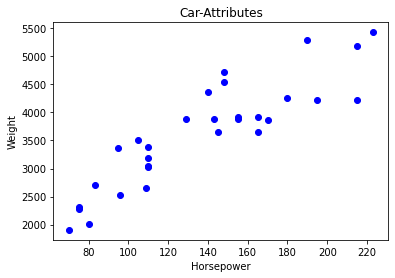

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

df_pandas = df_cars.toPandas() 
plt.plot( df_pandas ["hp"], df_pandas ["weight"],'bo' )
plt.ylabel('Weight')
plt.xlabel('Horsepower')
plt.title("Car-Attributes")
plt.show()

In [18]:
# Features (Modelamos mpg a partir del resto de datos)
from pyspark.ml.feature import VectorAssembler


assembler = VectorAssembler(
    inputCols=["displacement","hp","torque","CRatio","RARatio","CarbBarrells","NoOfSpeed","length","width","weight","automatic"],
    outputCol="features")

df_cars_features = assembler.transform(df_cars)
df_cars_features.show()

+-----+------------+---+------+------+-------+------------+---------+------+-----+------+---------+--------------------+
|  mpg|displacement| hp|torque|CRatio|RARatio|CarbBarrells|NoOfSpeed|length|width|weight|automatic|            features|
+-----+------------+---+------+------+-------+------------+---------+------+-----+------+---------+--------------------+
| 18.9|       350.0|165|   260|   8.0|   2.56|           4|        3| 200.3| 69.9|  3910|        1|[350.0,165.0,260....|
| 17.0|       350.0|170|   275|   8.5|   2.56|           4|        3| 199.6| 72.9|  3860|        1|[350.0,170.0,275....|
| 20.0|       250.0|105|   185|  8.25|   2.73|           1|        3| 196.7| 72.2|  3510|        1|[250.0,105.0,185....|
|18.25|       351.0|143|   255|   8.0|    3.0|           2|        3| 199.9| 74.0|  3890|        1|[351.0,143.0,255....|
|20.07|       225.0| 95|   170|   8.4|   2.76|           1|        3| 194.1| 71.8|  3365|        0|[225.0,95.0,170.0...|
| 11.2|       440.0|215|   330| 

In [19]:
# Split data
train, test = df_cars_features.select("mpg","features").randomSplit([0.8,0.2], seed=42)
train.show()
test.show()

+-----+--------------------+
|  mpg|            features|
+-----+--------------------+
| 11.2|[440.0,215.0,330....|
|13.27|[351.0,148.0,243....|
|13.77|[360.0,195.0,295....|
| 13.9|[351.0,148.0,243....|
|14.39|[500.0,190.0,360....|
|16.41|[318.0,145.0,255....|
| 16.5|[360.0,165.0,255....|
| 17.0|[350.0,170.0,275....|
| 17.8|[302.0,129.0,220....|
| 17.8|[350.0,155.0,250....|
| 18.9|[350.0,165.0,260....|
| 19.7|[258.0,110.0,195....|
|19.73|[318.0,140.0,255....|
| 20.0|[250.0,105.0,185....|
|20.07|[225.0,95.0,170.0...|
|21.47|[262.0,110.0,200....|
|21.47|[360.0,180.0,290....|
| 21.5|[171.0,109.0,146....|
|23.54|[231.0,110.0,175....|
| 23.9|[133.6,96.0,120.0...|
+-----+--------------------+
only showing top 20 rows

+-----+--------------------+
|  mpg|            features|
+-----+--------------------+
|13.27|[460.0,223.0,366....|
|14.89|[440.0,215.0,330....|
| 16.5|[350.0,155.0,250....|
|18.25|[351.0,143.0,255....|
| 20.3|[140.0,83.0,109.0...|
|22.12|[231.0,110.0,175....|
| 36.5|[85.3,80.0

In [20]:
# Train model
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(labelCol="mpg", maxIter=100, regParam=0.3, elasticNetParam=0.8)
model = lr.fit(train)

In [21]:
print (model.coefficients) 
print (model.intercept)
trSummary = model.summary
print ("numIterations: " + str(trSummary.totalIterations))
print ("Iteration Summary History: " + str(trSummary.objectiveHistory))
trSummary.residuals.show()
print ("RMSE: " + str(trSummary.rootMeanSquaredError))
print ("r2: " + str(trSummary.r2))

[-0.020094745260189763,-0.02187432039558865,0.0,2.8596093092681545,0.0,0.0,0.1920895876683277,0.0,0.0,-0.0019722838146656306,0.0]
11.216768509192315
numIterations: 92
Iteration Summary History: [0.5, 0.4005607819922413, 0.1507950452713826, 0.1480506776872756, 0.1372029038675859, 0.13619773650659617, 0.13462323237061233, 0.1345102367883969, 0.134406020406936, 0.13432715021263553, 0.13419944409424905, 0.13407470495203783, 0.13401267117783958, 0.13385626494312694, 0.1337819117419502, 0.13372681130641476, 0.13361262101895627, 0.1335946467023359, 0.13355851239893118, 0.13354612724147452, 0.13353078415407144, 0.13352176256582232, 0.13351559020993556, 0.13350476662822416, 0.13349539514635644, 0.13349224359651002, 0.133474773629811, 0.13345981063340426, 0.13341647174368476, 0.13340564080143263, 0.13339188617102843, 0.13338138240865893, 0.1333637709388418, 0.13335904831465706, 0.13334284256157247, 0.13333808576117878, 0.13333452629428347, 0.1333058578354482, 0.13328554378486585, 0.1332255570249

/home/jesus/universidad/Infraestructuras_Computacionales/practicas/TP2/sparkenv/lib/python3.8/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [22]:
# Predict model
predictions = model.transform(test)
predictions.show()

+-----+--------------------+------------------+
|  mpg|            features|        prediction|
+-----+--------------------+------------------+
|13.27|[460.0,223.0,366....| 9.838854364804599|
|14.89|[440.0,215.0,330....|11.470875229619812|
| 16.5|[350.0,155.0,250....|18.013713278617974|
|18.25|[351.0,143.0,255....|16.816444304397447|
| 20.3|[140.0,83.0,109.0...|  26.0518458288605|
|22.12|[231.0,110.0,175....|21.665553227433744|
| 36.5|[85.3,80.0,83.0,8...| 28.86546040264041|
+-----+--------------------+------------------+



In [23]:
# Model evalluation
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="mpg")
rmse = evaluator.evaluate(predictions)
print ("Root Mean Squared Error = {0:.4f}".format(rmse))
evaluator.setMetricName("mse")
mse = evaluator.evaluate(predictions)
print ("Mean Squared Error = {0:.4f}".format(mse))

Root Mean Squared Error = 4.1298
Mean Squared Error = 17.0551
